In [1]:
# !pip install torch
# !pip install transformers
# !pip install pandas
# !pip install matplotlib
# !pip install protobuf #for polish bert
# !pip install sacremoses #for polish bert
# !pip install scikit-learn
# !pip install wandb
# !pip show accelerate


In [2]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
path = "./suggested_train_expert.csv"

df_org= pd.read_csv(path)
df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,category,text
1780,Analiza systemów energetycznych: porównanie ró...,Scenariusze czasowe: ile MW/MWhel OZE realisty...
9132,Społeczna akceptacja inwestycji i planowanie k...,Aspekty społeczne i akceptacja publiczna: jak ...
2859,Analiza i rozwój krajowego łańcucha dostaw ene...,"Informacje o transferze technologii, warunkach..."
7109,Bezpieczeństwo reaktorów jądrowych - analiza d...,Historyczne dane o poprzednich przestojach rea...
10112,Tempo produkcji broni jądrowej przez Koreę Pół...,"Dokładne, odniesione do źródeł wielkości zapas..."


In [5]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Analiza systemów energetycznych: porównanie różnych scenariuszy wykorzystania źródeł energii odnawialnej, magazynów energii i gazu ziemnego',
 'Społeczna akceptacja inwestycji i planowanie komunikacji społecznej',
 'Analiza i rozwój krajowego łańcucha dostaw energii jądrowej',
 'Bezpieczeństwo reaktorów jądrowych - analiza danych historycznych i porównawcza',
 'Tempo produkcji broni jądrowej przez Koreę Północną',
 'Harmonogram procedur regulacyjnych i budowlanych projektu jądrowego',
 'Bezpieczeństwo elektrowni jądrowej Akkuyu - raporty inspekcyjne MAEA i niezależne audyty ekspertów',
 'Ocena ryzyka awarii jądrowej poprzez modelowanie scenariuszy awaryjnych i rozprzestrzeniania emisji radionuklidów',
 'Zasilanie awaryjne i systemy chłodzenia - raport szczegółowy',
 'Struktura finansowania projektów inwestycyjnych',
 'Planowanie i ćwiczenia transgranicznej ochrony ludności przed zagrożeniami radiacyjnymi',
 'Analiza wrażliwości projektów energetycznych na opóźnienia i przekroczenia k

In [6]:
for key, value in enumerate(labels):
    print(value)

Analiza systemów energetycznych: porównanie różnych scenariuszy wykorzystania źródeł energii odnawialnej, magazynów energii i gazu ziemnego
Społeczna akceptacja inwestycji i planowanie komunikacji społecznej
Analiza i rozwój krajowego łańcucha dostaw energii jądrowej
Bezpieczeństwo reaktorów jądrowych - analiza danych historycznych i porównawcza
Tempo produkcji broni jądrowej przez Koreę Północną
Harmonogram procedur regulacyjnych i budowlanych projektu jądrowego
Bezpieczeństwo elektrowni jądrowej Akkuyu - raporty inspekcyjne MAEA i niezależne audyty ekspertów
Ocena ryzyka awarii jądrowej poprzez modelowanie scenariuszy awaryjnych i rozprzestrzeniania emisji radionuklidów
Zasilanie awaryjne i systemy chłodzenia - raport szczegółowy
Struktura finansowania projektów inwestycyjnych
Planowanie i ćwiczenia transgranicznej ochrony ludności przed zagrożeniami radiacyjnymi
Analiza wrażliwości projektów energetycznych na opóźnienia i przekroczenia kosztów
Analiza prawno-międzynarodowa i strateg

In [7]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [8]:
label2id

{'Analiza systemów energetycznych: porównanie różnych scenariuszy wykorzystania źródeł energii odnawialnej, magazynów energii i gazu ziemnego': 0,
 'Społeczna akceptacja inwestycji i planowanie komunikacji społecznej': 1,
 'Analiza i rozwój krajowego łańcucha dostaw energii jądrowej': 2,
 'Bezpieczeństwo reaktorów jądrowych - analiza danych historycznych i porównawcza': 3,
 'Tempo produkcji broni jądrowej przez Koreę Północną': 4,
 'Harmonogram procedur regulacyjnych i budowlanych projektu jądrowego': 5,
 'Bezpieczeństwo elektrowni jądrowej Akkuyu - raporty inspekcyjne MAEA i niezależne audyty ekspertów': 6,
 'Ocena ryzyka awarii jądrowej poprzez modelowanie scenariuszy awaryjnych i rozprzestrzeniania emisji radionuklidów': 7,
 'Zasilanie awaryjne i systemy chłodzenia - raport szczegółowy': 8,
 'Struktura finansowania projektów inwestycyjnych': 9,
 'Planowanie i ćwiczenia transgranicznej ochrony ludności przed zagrożeniami radiacyjnymi': 10,
 'Analiza wrażliwości projektów energetyczny

In [9]:
id2label

{0: 'Analiza systemów energetycznych: porównanie różnych scenariuszy wykorzystania źródeł energii odnawialnej, magazynów energii i gazu ziemnego',
 1: 'Społeczna akceptacja inwestycji i planowanie komunikacji społecznej',
 2: 'Analiza i rozwój krajowego łańcucha dostaw energii jądrowej',
 3: 'Bezpieczeństwo reaktorów jądrowych - analiza danych historycznych i porównawcza',
 4: 'Tempo produkcji broni jądrowej przez Koreę Północną',
 5: 'Harmonogram procedur regulacyjnych i budowlanych projektu jądrowego',
 6: 'Bezpieczeństwo elektrowni jądrowej Akkuyu - raporty inspekcyjne MAEA i niezależne audyty ekspertów',
 7: 'Ocena ryzyka awarii jądrowej poprzez modelowanie scenariuszy awaryjnych i rozprzestrzeniania emisji radionuklidów',
 8: 'Zasilanie awaryjne i systemy chłodzenia - raport szczegółowy',
 9: 'Struktura finansowania projektów inwestycyjnych',
 10: 'Planowanie i ćwiczenia transgranicznej ochrony ludności przed zagrożeniami radiacyjnymi',
 11: 'Analiza wrażliwości projektów energety

In [10]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [11]:
df_org[0:20]

,category,text,labels
1780,Analiza systemów energetycznych: porównanie ró...,Scenariusze czasowe: ile MW/MWhel OZE realisty...,0
9132,Społeczna akceptacja inwestycji i planowanie k...,Aspekty społeczne i akceptacja publiczna: jak ...,1
2859,Analiza i rozwój krajowego łańcucha dostaw ene...,"Informacje o transferze technologii, warunkach...",2
7109,Bezpieczeństwo reaktorów jądrowych - analiza d...,Historyczne dane o poprzednich przestojach rea...,3
10112,Tempo produkcji broni jądrowej przez Koreę Pół...,"Dokładne, odniesione do źródeł wielkości zapas...",4
5153,Harmonogram procedur regulacyjnych i budowlany...,Ocena regulacyjnych i prawnych barier w Polsce...,5
7257,Bezpieczeństwo elektrowni jądrowej Akkuyu - ra...,Raporty inspekcyjne MAEA lub innych niezależny...,6
1155,Ocena ryzyka awarii jądrowej poprzez modelowan...,Opis procedur środowiskowych i przyczyn liczny...,7
3131,Zasilanie awaryjne i systemy chłodzenia - rapo...,Oświadczenie operatora systemu przesyłowego o ...,8
3209,Zasilanie awaryjne i systemy chłodzenia - rapo...,Szczegółowe zapisy testów generatorów awaryjny...,8


<Axes: ylabel='count'>

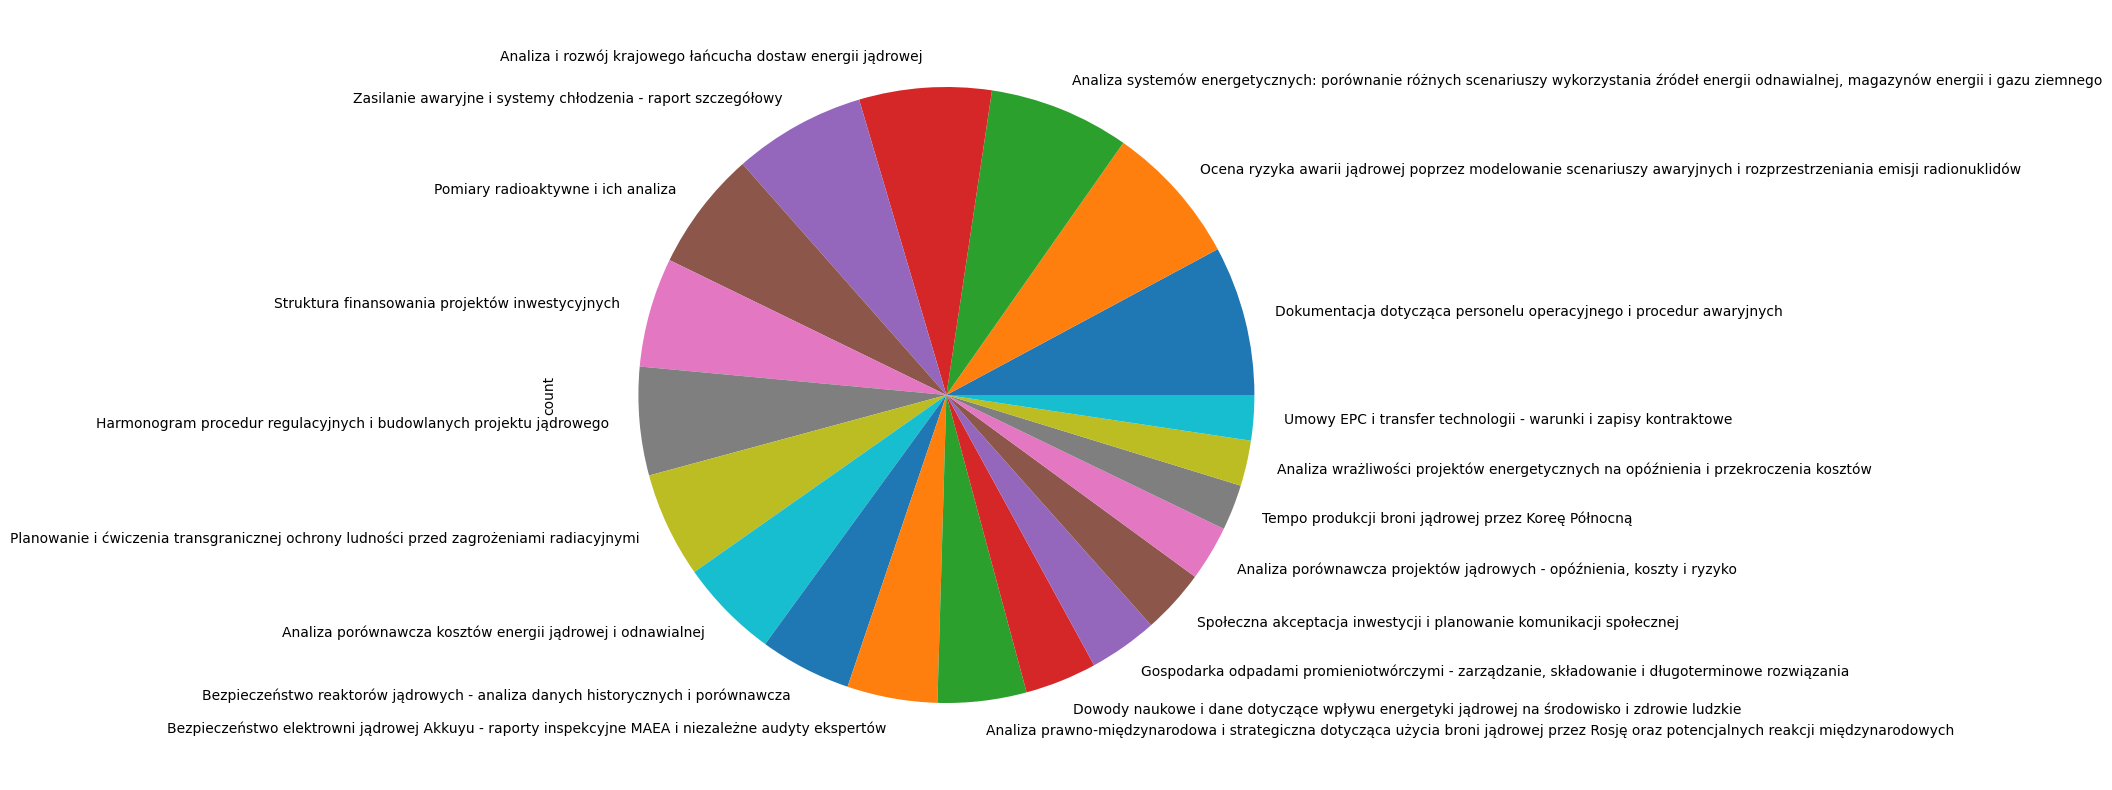

In [12]:
import matplotlib.pyplot as plt

df_org.category.value_counts().plot(kind='pie', figsize=(10,10))

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "allegro/herbert-base-cased",
    max_length=512
)


In [14]:
model = BertForSequenceClassification.from_pretrained("allegro/herbert-base-cased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
#prepare val and test sets

test_path = './suggested_test_expert.csv'
val_path = './suggested_validation_expert.csv'

df_test = pd.read_csv(test_path)
df_val = pd.read_csv(val_path)

In [16]:
df_test["labels"]=df_test.category.map(lambda x: label2id[x.strip()])
df_test = df_test.sample(frac=1.0, random_state=42)
df_test[0:20]


,category,text,labels
1214,Umowy EPC i transfer technologii - warunki i z...,Stan dostępności i kontraktów kluczowych dosta...,16
1161,Analiza porównawcza projektów jądrowych - opóź...,Doświadczenia KHNP z projektami zagranicznymi:...,18
422,Zasilanie awaryjne i systemy chłodzenia - rapo...,Dokładny timeline: czasy utraty i przywrócenia...,8
976,Analiza prawno-międzynarodowa i strategiczna d...,Perspektywa IAEA i stanowisko międzynarodowe (...,12
793,Analiza porównawcza kosztów energii jądrowej i...,Szacunki kosztów CAPEX i LCOE dla proponowanyc...,13
785,Analiza porównawcza kosztów energii jądrowej i...,"Szacunkowe, zróżnicowane zakresy kosztów budow...",13
23,Dokumentacja dotycząca personelu operacyjnego ...,Dokładniejsze omówienie zdolności technicznych...,14
405,Zasilanie awaryjne i systemy chłodzenia - rapo...,"Szczegóły systemów awaryjnych: liczba, moc i s...",8
43,Dokumentacja dotycząca personelu operacyjnego ...,Informacje o bieżącym stanie dostępu i warunka...,14
582,Struktura finansowania projektów inwestycyjnych,"Proponowany model finansowania (udziały, gwara...",9


In [17]:
df_val["labels"]=df_val.category.map(lambda x: label2id[x.strip()])
df_val = df_val.sample(frac=1.0, random_state=42)
df_val[0:20]

,category,text,labels
1245,Umowy EPC i transfer technologii - warunki i z...,Konkretne warunki kontraktowe (ryczałt/unit-pr...,16
727,Planowanie i ćwiczenia transgranicznej ochrony...,Ocena potencjalnego długoterminowego wpływu na...,10
622,Struktura finansowania projektów inwestycyjnych,Szczegóły dotyczące struktury kapitałowej po p...,9
898,Bezpieczeństwo elektrowni jądrowej Akkuyu - ra...,"Ocena niezależnego, międzynarodowego regulator...",6
1205,Analiza wrażliwości projektów energetycznych n...,Szacunkowe oszczędności czasu i kosztów wynika...,11
1197,Analiza wrażliwości projektów energetycznych n...,Szczegółowa analiza głównych źródeł ryzyka dla...,11
247,Analiza systemów energetycznych: porównanie ró...,Więcej danych dotyczących harmonogramu prac PS...,0
590,Struktura finansowania projektów inwestycyjnych,Szczegóły dotyczące wpływu na dług publiczny: ...,9
298,Analiza i rozwój krajowego łańcucha dostaw ene...,Konkretny plan rozwoju kadr (liczby szkolonych...,2
422,Zasilanie awaryjne i systemy chłodzenia - rapo...,"Informacje o statusie awaryjnym reaktora (moc,...",8


In [18]:
train_texts= list(df_org.text)
val_texts= list(df_val.text)
test_texts= list(df_test.text)
train_labels= list(df_org.labels)
val_labels= list(df_val.labels)
test_labels= list(df_test.labels)

In [19]:
len(train_texts), len(val_texts), len(test_texts)

(10242, 1285, 1270)

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [21]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [22]:
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataset = DataLoader(test_encodings, test_labels)

In [23]:
# pobranie jednego przykładu, np. o indeksie 0
example = train_dataloader[0]

print(example.keys())           # zobaczysz dict: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
print(example['input_ids'])     # tensor z tokenami tekstu
print(example['labels'])        # tensor z etykietą

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tensor([    0, 36600, 14043, 37446,  1335,  4410, 16599,  1888,    49,    59,
         3645,  1040,    51, 30248,  3264, 11042,  2545,  9862,  1019,  3023,
         1019,  1008,  1750,  1947,  2293,  1750,  1947,  2431,  1750, 10222,
        21958,  2602,  2408, 45526, 39799,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1])
tensor(0)


In [24]:
tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
print(tokens)

['<s>', 'Scenari', 'usze</w>', 'czasowe</w>', ':</w>', 'ile</w>', 'MW</w>', '/</w>', 'M', 'W', 'he', 'l</w>', 'O', 'ZE</w>', 'reali', 'stycznie</w>', 'można</w>', 'dodać</w>', 'w</w>', 'Polsce</w>', 'w</w>', '5</w>', '-</w>', ',</w>', '10</w>', '-</w>', ',</w>', '15</w>', '-</w>', 'letnich</w>', 'horyzon', 'tach</w>', 'przy</w>', 'wskazanych</w>', 'inwestycjach</w>', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [25]:
from transformers import TrainingArguments, Trainer

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [27]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir="./results", 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    report_to="wandb",       
    run_name="bert_polish_run",
    eval_strategy="steps", #evaluation_strategy="steps" for older versions
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [28]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

In [29]:
trainer.train()

wandb: Currently logged in as: eoplumbum (eoplumbum-korea-advanced-institute-of-science-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,2.953100,2.706565,0.266926,0.150758,0.181250,0.193298
100,2.008900,1.311209,0.635798,0.544911,0.625866,0.566403
150,1.100900,0.920241,0.736965,0.691714,0.756250,0.683787
200,0.779500,0.737578,0.789883,0.768611,0.797351,0.762666
250,0.616300,0.684343,0.797665,0.784440,0.802628,0.781553
300,0.602300,0.624408,0.807004,0.788702,0.803119,0.786710
350,0.437300,0.618426,0.817121,0.806490,0.821147,0.805186
400,0.373900,0.590791,0.824903,0.817769,0.825371,0.817374
450,0.318900,0.562624,0.832685,0.821569,0.830201,0.819595


/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eoplumbum/miniconda3/envs/bert_pl/lib/py

TrainOutput(global_step=483, training_loss=0.9730163341229994, metrics={'train_runtime': 168.3669, 'train_samples_per_second': 182.494, 'train_steps_per_second': 2.869, 'total_flos': 1373929970372784.0, 'train_loss': 0.9730163341229994, 'epoch': 3.0})

In [30]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/eoplumbum/miniconda3/envs/bert_pl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.197498,0.953525,0.949222,0.950684,0.947968
val,0.556470,0.831128,0.820174,0.827004,0.819456
test,0.508300,0.840945,0.830444,0.834372,0.829806


In [32]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
# Test with a an example text 
text = "Koszty ekonomiczne: inwestycja, eksploatacja, demontaż i utylizacja paliwa vs alternatywy grzewcze"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[9.1201e-01, 3.5623e-03, 1.6899e-03, 2.8838e-03, 3.2547e-03, 5.3399e-04,
          1.4108e-03, 2.9239e-03, 2.3617e-03, 4.8267e-03, 1.5827e-03, 1.5833e-02,
          1.5071e-03, 2.7494e-02, 3.7006e-04, 1.4940e-03, 1.7018e-03, 1.0821e-02,
          2.4554e-03, 1.2836e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'Analiza systemów energetycznych: porównanie różnych scenariuszy wykorzystania źródeł energii odnawialnej, magazynów energii i gazu ziemnego')

In [45]:
pred_label = predict(text)[2]
print(pred_label)

Analiza systemów energetycznych: porównanie różnych scenariuszy wykorzystania źródeł energii odnawialnej, magazynów energii i gazu ziemnego


In [34]:
model_path = "polish-expert-missing-information-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('polish-expert-missing-information-classification-model/tokenizer_config.json',
 'polish-expert-missing-information-classification-model/special_tokens_map.json',
 'polish-expert-missing-information-classification-model/vocab.json',
 'polish-expert-missing-information-classification-model/merges.txt',
 'polish-expert-missing-information-classification-model/added_tokens.json',
 'polish-expert-missing-information-classification-model/tokenizer.json')

In [ ]:
path_amie = '/home/eoplumbum/classfier/addressed_missing_info_expert.csv'
df_amie= pd.read_csv(path_amie)

df_amie['text'].head()

predict(text)

0    Dokładna informacja o stanie cyfrowych kopii z...
1    Dokumentacja ageing management (zarządzanie st...
2    Stan i zdolność pomp poboru wody (wydajności, ...
3    Wiek, materiał i pełna historia przeglądów, re...
4    Kopie lub streszczenia protokołów z „gorących ...
Name: text, dtype: object

In [ ]:
# Test on 20 examples
df_amie_subset = df_amie.head(20).copy()
df_amie_subset['predictions'] = [predict(text)[2] for text in df_amie_subset['text']]

df_amie_subset[['text', 'predictions']].to_csv("df_amie_predictions_20.csv", index=False)


socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.


In [ ]:
# For the whole dataset

df_amie['predictions'] = [predict(text)[2] for text in df_amie['text']]
df_amie[['text', 'predictions']].to_csv("df_amie_predictions.csv", index=False)


socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.


In [ ]:
path_amie_predictions = './df_amie_predictions.csv'
df_amie_predictions = pd.read_csv(path_amie_predictions)
len(df_amie_predictions)

socket.send() raised exception.
socket.send() raised exception.


11224

socket.send() raised exception.
socket.send() raised exception.


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [52]:
# Load local model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)

# Push to Hugging Face (if you're logged in)
model.push_to_hub("eoplumbum/polish-herbert-expert-missing-info")
tokenizer.push_to_hub("eoplumbum/polish-herbert-expert-missing-info")

socket.send() raised exception.
socket.send() raised exception.
model.safetensors: 100%|██████████| 498M/498M [00:32<00:00, 15.3MB/s] 


CommitInfo(commit_url='https://huggingface.co/eoplumbum/polish-herbert-expert-missing-info/commit/636ea2a53936bb263ca00f057d49cb089fd51c1f', commit_message='Upload tokenizer', commit_description='', oid='636ea2a53936bb263ca00f057d49cb089fd51c1f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/eoplumbum/polish-herbert-expert-missing-info', endpoint='https://huggingface.co', repo_type='model', repo_id='eoplumbum/polish-herbert-expert-missing-info'), pr_revision=None, pr_num=None)

socket.send() raised exception.
socket.send() raised exception.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "eoplumbum/polish-herbert-expert-missing-info"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

text = "Koszty ekonomiczne: inwestycja, eksploatacja, demontaż i utylizacja paliwa vs alternatywy grzewcze"

inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

with torch.no_grad():
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    pred_idx = probs.argmax(dim=1).item()

pred_label = model.config.id2label[pred_idx]
print(f"Prediction: {pred_label}, Probabilities: {probs}")


socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.


Predykcja: Analiza systemów energetycznych: porównanie różnych scenariuszy wykorzystania źródeł energii odnawialnej, magazynów energii i gazu ziemnego, Prawdopodobieństwa: tensor([[9.1201e-01, 3.5623e-03, 1.6899e-03, 2.8838e-03, 3.2547e-03, 5.3399e-04,
         1.4108e-03, 2.9239e-03, 2.3617e-03, 4.8267e-03, 1.5827e-03, 1.5833e-02,
         1.5071e-03, 2.7494e-02, 3.7006e-04, 1.4940e-03, 1.7018e-03, 1.0821e-02,
         2.4554e-03, 1.2836e-03]])
